In [177]:
from openvino.inference_engine import IECore
import matplotlib.pyplot as plt
import cv2
import numpy as np
ie = IECore()

In [178]:
image = r'data/GettyImages-1092658864_hero-1024x575.webp'
image = cv2.imread(image)

In [180]:
def show(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [181]:
def Face_Detection(image):
    model_xml = r'models\face-detection-adas-0001\face-detection-adas-0001.xml'
    model_bin = r'models\face-detection-adas-0001\face-detection-adas-0001.bin'
    net = ie.read_network(model=model_xml, weights=model_bin)
    exec_net = ie.load_network(network=net, device_name='CPU')
    input_name = next(iter(net.input_info))
    input_info = net.input_info[input_name]
    n, c, h, w = input_info.tensor_desc.dims
    resized_image = cv2.resize(image, (w, h))
    input_data = resized_image.transpose((2, 0, 1))
    output = exec_net.infer(inputs={input_name: input_data})

    # Process the output data
    output_name = next(iter(net.outputs))
    output_data = output[output_name]
    boxes = output_data[0][0]  # Assuming a single image was processed



    # Loop through the detected faces and draw bounding boxes on the image
    Number_Of_Faces = 0
    for box in boxes:
        confidence = box[2]
        if confidence > 0.5:  # Filter detections based on confidence threshold
            Number_Of_Faces += 1
            x_min = int(box[3] * image.shape[1])
            y_min = int(box[4] * image.shape[0])
            x_max = int(box[5] * image.shape[1])
            y_max = int(box[6] * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    show(image)
    # Display the image with bounding boxes
    return boxes, Number_Of_Faces


In [182]:
def show_points(image,boxes,Number_Of_Faces):    
    model_xml_landmarks = r'models\facial-landmarks-35-adas-0002\facial-landmarks-35-adas-0002.xml'
    model_bin_landmarks = r'models\facial-landmarks-35-adas-0002\facial-landmarks-35-adas-0002.bin'
    net_landmarks = ie.read_network(model=model_xml_landmarks, weights=model_bin_landmarks)
    exec_net_landmarks = ie.load_network(network=net_landmarks, device_name='CPU')

    # Prepare input data for the facial landmarks detection model
    input_name_landmarks = next(iter(net_landmarks.input_info))
    input_info_landmarks = net_landmarks.input_info[input_name_landmarks]
    n_landmarks, c_landmarks, h_landmarks, w_landmarks = input_info_landmarks.tensor_desc.dims
    for i in range(Number_Of_Faces):
        face_box = boxes[i]  # Assuming only one face is detected
        x_min = int(face_box[3] * image.shape[1])
        y_min = int(face_box[4] * image.shape[0])
        x_max = int(face_box[5] * image.shape[1])
        y_max = int(face_box[6] * image.shape[0])

        face_image = image[y_min:y_max, x_min:x_max]
        face_resized = cv2.resize(face_image, (w_landmarks, h_landmarks))
        input_data_landmarks = face_resized.transpose((2, 0, 1))
        output_landmarks = exec_net_landmarks.infer(inputs={input_name_landmarks: input_data_landmarks})

        # Process the output of the facial landmarks detection model
        output_name_landmarks = next(iter(net_landmarks.outputs))
        landmarks = output_landmarks[output_name_landmarks]
        # Reshape the landmarks into pairs of x and y coordinates
        count = 0
        points = 0
        mark = []
        landmarks_xy = landmarks.reshape(-1, 2)
        for landmark in landmarks_xy:
            x, y = landmark
            
            # Apply scaling factor to make the landmarks more visible
            x = int(x * (x_max - x_min) + x_min)
            y = int(y * (y_max - y_min) + y_min)
            if count<2:
             mark.append(x)
             mark.append(y)
             count+=1
            plt.scatter(x, y, c='red', s=5)
            points+=1  # Plot each landmark as a red dot


    show(image)
    return mark

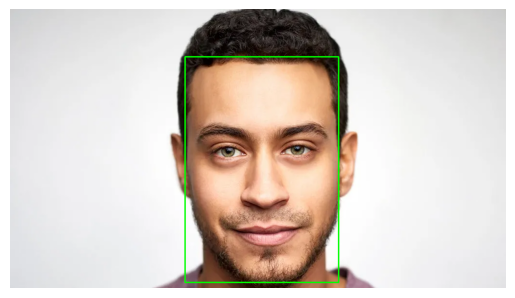

In [183]:
boxes , Number_Of_Faces= Face_Detection(image)

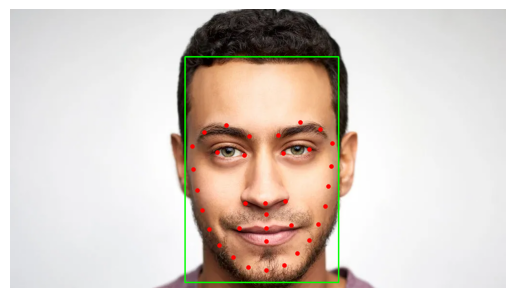

In [185]:
landmarks_xy = show_points(image, boxes, Number_Of_Faces)
first = landmarks_xy[:3:2]
secound = landmarks_xy[1::2]

In [129]:
def Eye_Detection(image, scatter_points):
    eye_xml = r'models\open_closed_eye\open_closed_eye.xml'
    eye_bin = r'models\open_closed_eye\open_closed_eye.bin'
    net_eye = ie.read_network(model=eye_xml, weights=eye_bin)
    ext_eye = ie.load_network(network=net_eye, device_name='CPU')

    input_name = next(iter(net_eye.input_info))
    input_info = net_eye.input_info[input_name]
    n_landmarks, c_landmarks, h_landmarks, w_landmarks = input_info.tensor_desc.dims
        # Extract the eye region using the scatter points
    x_min = int(scatter_points[0][0] - 0.5)
    y_min = int(scatter_points[0][1] - 0.5)
    x_max = int(scatter_points[1][0] - 0.5)
    y_max = int(scatter_points[1][1] + 0.5)

    # Check if the coordinates are within the image boundaries
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(image.shape[1], x_max)
    y_max = min(image.shape[0], y_max)

    # Check if the eye region is valid
    if x_max > x_min and y_max > y_min:
        # Adjust the indices to extract the eye region
        eye_region = image[y_min:y_max, x_min:x_max]

        # Display the eye region
        show(eye_region)
    else:
        print("Invalid eye region")

    resized_image = cv2.resize(eye_region, (w_landmarks, h_landmarks))
    input_data = resized_image.transpose((2, 0, 1))
    input_data = np.expand_dims(input_data, axis=0)

    outputs = ext_eye.infer(inputs={input_name: input_data})
    output_layer_name = "19"  # Replace with the actual output layer name
    output_data = outputs[output_layer_name]

    predicted_class = np.argmax(output_data)

    class_labels = ["open", "closed"]
    predicted_label = class_labels[predicted_class]

    return predicted_label

In [130]:
Eye_Detection(image, )  # Assuming you want to detect eyes for the first face box

Invalid eye region


UnboundLocalError: local variable 'eye_region' referenced before assignment

In [136]:
landmarks_xy[0]

array([0.38334334, 0.43377998], dtype=float32)

In [137]:
for landmark in landmarks_xy:
    x, y = landmark
    # Apply scaling factor to make the landmarks more visible
    x = int(x * (x_max - x_min) + x_min)
    y = int(y * (y_max - y_min) + y_min)
    plt.scatter(x, y, c='red', s=5)  # Plot each landmark as a red dot
        


IndentationError: unexpected indent (1489542170.py, line 2)